# Installations

In [ ]:
!pip install boto3 awscli -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.


# Imports

In [ ]:
# --- System and Utility Imports ---
import os
import random
import datetime
from collections import Counter

# --- AWS and Cloud Utilities ---
import boto3
from botocore.exceptions import NoCredentialsError

# --- Image and Video Processing ---
from PIL import Image
import cv2

# --- Data Handling ---
import numpy as np
import pandas as pd

# --- Data Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning & Deep Learning ---
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- Model Evaluation ---
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# --- Progress Tracking ---
from tqdm import tqdm

# --- Check AWS CLI version ---
!aws --version

aws-cli/1.40.26 Python/3.11.12 Linux/6.1.123+ botocore/1.38.27


# Global Variables

In [ ]:
SEED = 42
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
S3_BUCKET_NAME = 'lung-cancer-project-data'
S3_DATA_PREFIX = 'datasets/ct/'
LOCAL_DATASET_PATH = '/content/drive/MyDrive/lung-cancer-project-data/datasets/ct'

# AWS Credentials

In [ ]:
os.environ["AWS_ACCESS_KEY_ID"] = "xxxxxxxxxxxxxxxxxxxxxxx"
os.environ["AWS_SECRET_ACCESS_KEY"] = "xxxxxxxxxxxxxxxxxxxxxxx"
os.environ["AWS_DEFAULT_REGION"] = "ap-south-1"

# Exploratory Data Analysis

## EDA on the Training Dataset

Classes found in 'train': ['benign', 'malignant', 'normal']

 Image Count per Class:
        Class  Image Count
0     benign          820
1  malignant         1317
2     normal          746

 Image Shape Distribution (from 5 samples/class):
       Width  Height
count   15.0    15.0
mean   224.0   224.0
std      0.0     0.0
min    224.0   224.0
25%    224.0   224.0
50%    224.0   224.0
75%    224.0   224.0
max    224.0   224.0


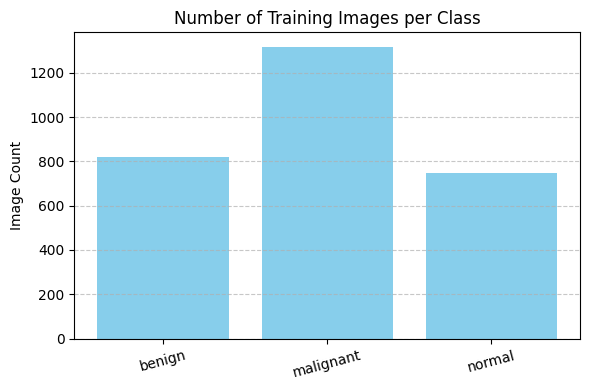

In [ ]:
train_dir = os.path.join(LOCAL_DATASET_PATH, 'train')
categories = sorted(os.listdir(train_dir))

print("Classes found in 'train':", categories)

# Count images per class
class_counts = {}
image_shapes = []

for category in categories:
    class_path = os.path.join(train_dir, category)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[category] = len(image_files)

    # Sample image shape extraction
    for img_file in image_files[:5]:  # Just 5 per class to avoid I/O overhead
        img = Image.open(os.path.join(class_path, img_file))
        image_shapes.append(img.size)
        img.close()

# Printing class counts
df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])
print("\n Image Count per Class:\n", df_counts)

# Image resolution stats
res_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])
print("\n Image Shape Distribution (from 5 samples/class):")
print(res_df.describe())

# Number of Training Images per Class: Bar chart
plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Number of Training Images per Class')
plt.ylabel('Image Count')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Analyze sample image for mode, shape, channels, and color distribution


 Sample image path: /content/drive/MyDrive/lung-cancer-project-data/datasets/ct/train/benign/ct_train_benign_Bengin case (104)_aug0.jpg
 Image shape (H, W, Channels): (224, 224, 3)
 Image mode (PIL): RGB

 Sample pixel array (top-left corner):
[[[0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]]]

 RGB Channel Mean Values: [112.71211336 112.71211336 112.71211336]
 RGB Channel Std Dev Values: [68.56714994 68.56714994 68.56714994]


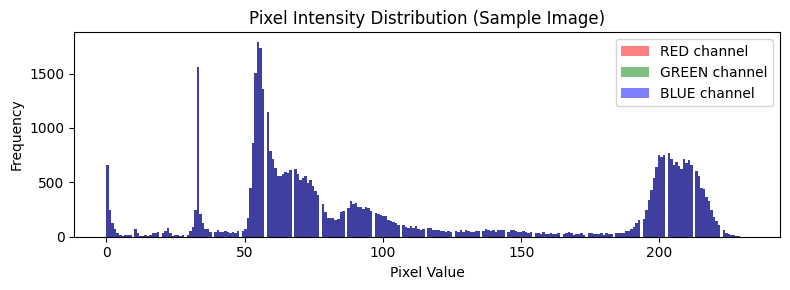

In [ ]:
sample_path = os.path.join(train_dir, categories[0], os.listdir(os.path.join(train_dir, categories[0]))[0])
img = Image.open(sample_path)
img_np = np.array(img)

print(f"\n Sample image path: {sample_path}")
print(f" Image shape (H, W, Channels): {img_np.shape}")
print(f" Image mode (PIL): {img.mode}")

# Show pixel array (only top-left corner for readability)
print("\n Sample pixel array (top-left corner):")
print(img_np[:3, :3])  # print top-left 3x3 region

# Per channel statistics if image is RGB
if img.mode == "RGB" and len(img_np.shape) == 3:
    channel_means = np.mean(img_np, axis=(0, 1))
    channel_stds = np.std(img_np, axis=(0, 1))
    print("\n RGB Channel Mean Values:", channel_means)
    print(" RGB Channel Std Dev Values:", channel_stds)

    # Plot channel distributions
    plt.figure(figsize=(8, 3))
    colors = ['red', 'green', 'blue']
    for i in range(3):
        plt.hist(img_np[:, :, i].ravel(), bins=256, color=colors[i], alpha=0.5, label=f'{colors[i].upper()} channel')
    plt.title("Pixel Intensity Distribution (Sample Image)")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Image is not in RGB format or has unexpected shape. Skipping color analysis.")

img.close()

## Sample images

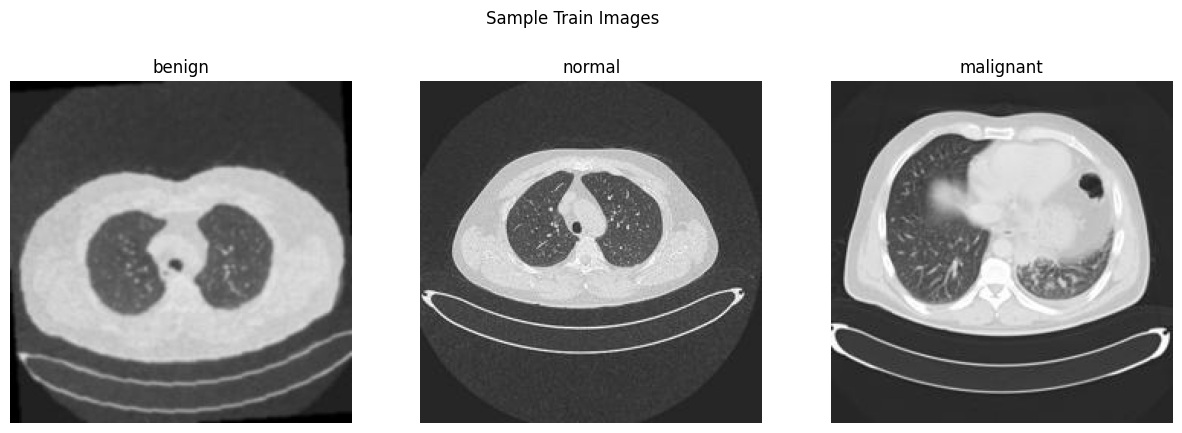

In [ ]:
def plot_sample_images(directory, title):
    categories = os.listdir(directory)
    plt.figure(figsize=(15, 5))
    for i, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        sample_image = os.listdir(category_path)[0]
        img = tf.keras.utils.load_img(os.path.join(category_path, sample_image))
        plt.subplot(1, len(categories), i + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_sample_images(os.path.join(LOCAL_DATASET_PATH, 'train'), 'Sample Train Images')

# Data Preprocessing + Augmentation

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = datagen.flow_from_directory(
    os.path.join(LOCAL_DATASET_PATH, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)
val_generator = datagen.flow_from_directory(
    os.path.join(LOCAL_DATASET_PATH, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_generator = datagen.flow_from_directory(
    os.path.join(LOCAL_DATASET_PATH, 'test'),
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 2883 images belonging to 3 classes.
Found 360 images belonging to 3 classes.
Found 699 images belonging to 3 classes.


# Build Model (Resnet50)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Train Model

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 829s 9s/step - accuracy: 0.5710 - loss: 0.9817 - val_accuracy: 0.9083 - val_loss: 0.2661
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 665s 7s/step - accuracy: 0.9001 - loss: 0.3065 - val_accuracy: 0.9500 - val_loss: 0.1756
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 658s 7s/step - accuracy: 0.9186 - loss: 0.2198 - val_accuracy: 0.9583 - val_loss: 0.1359
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 660s 7s/step - accuracy: 0.9456 - loss: 0.1667 - val_accuracy: 0.9583 - val_loss: 0.1250
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 640s 7s/step - accuracy: 0.9554 - loss: 0.1377 - val_accuracy: 0.9639 - val_loss: 0.1137
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 635s 7s/step - accuracy: 0.9610 - loss: 0.1295 - val_accuracy: 0.9611 - val_loss: 0.1056
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 638s 7s/step - accuracy: 0.9612 - loss: 0.1180 - val_accuracy: 0.9694 - val_loss: 0.1001
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 635s 7s/step - accuracy: 0.9691 - loss: 0.0977 - val_accuracy: 0.9667 - v

# Save Model and Logs

In [ ]:
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_filename = f"resnet50_ct_model_{timestamp}.h5"
log_filename = f"resnet50_ct_log_{timestamp}.txt"

model.save(model_filename)

with open(log_filename, 'w') as f:
    f.write("ResNet50 CT Classification Training Log\n\n")
    f.write(str(history.history))

S3_MODEL_PATH = f"model-artifacts/ct_test_models/{model_filename}"
S3_LOG_PATH = f"logs/ct/resnet50/{log_filename}"

s3_client = boto3.client('s3')

try:
    print("Uploading model to S3...")
    s3_client.upload_file(model_filename, S3_BUCKET_NAME, S3_MODEL_PATH)

    print("Uploading log to S3...")
    s3_client.upload_file(log_filename, S3_BUCKET_NAME, S3_LOG_PATH)

    print("Upload complete.")
except NoCredentialsError:
    print("AWS credentials not found. Please check environment variables.")

Uploading model to S3...
Uploading log to S3...
Upload complete.


# Evaluate Model

In [ ]:
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_labels, target_names=list(test_generator.class_indices.keys())))

699/699 ━━━━━━━━━━━━━━━━━━━━ 216s 304ms/step
              precision    recall  f1-score   support

      benign       0.95      0.95      0.95        87
   malignant       0.98      1.00      0.99       426
      normal       0.98      0.94      0.96       186

    accuracy                           0.98       699
   macro avg       0.97      0.96      0.97       699
weighted avg       0.98      0.98      0.98       699



## Confusion Matrix

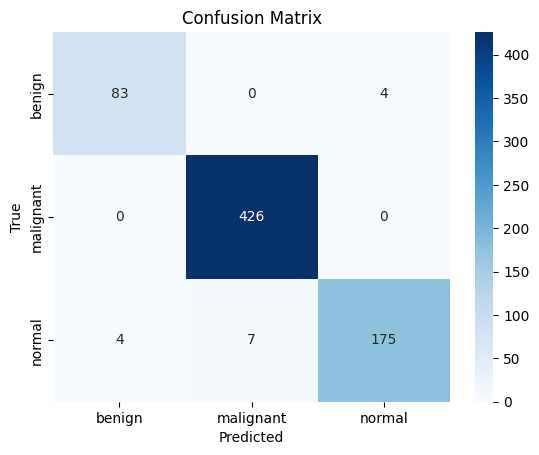

In [ ]:
cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## ROC AUC per class

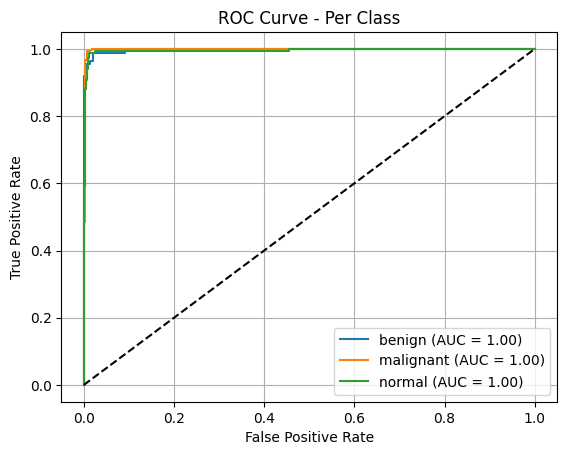

In [ ]:
y_true_bin = label_binarize(y_true, classes=list(range(train_generator.num_classes)))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(train_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{list(test_generator.class_indices.keys())[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Per Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

## Overall ROC Curve (Micro-Average)

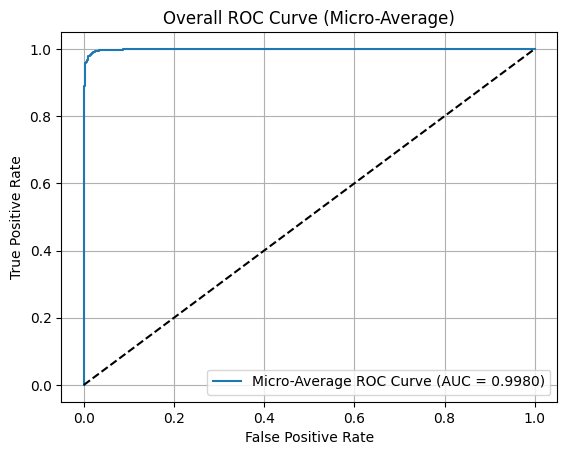

Overall Micro-Average AUC Score: 0.9980


In [ ]:
micro_fpr, micro_tpr, _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
micro_auc = auc(micro_fpr, micro_tpr)

plt.figure()
plt.plot(micro_fpr, micro_tpr, label=f'Micro-Average ROC Curve (AUC = {micro_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Overall ROC Curve (Micro-Average)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

print(f"Overall Micro-Average AUC Score: {micro_auc:.4f}")

# Summary – CT Image Classification using ResNet50

This notebook presents a complete pipeline for classifying CT images into three categories: **benign**, **malignant**, and **normal**, using a **ResNet50-based convolutional neural network**. The process follows a methodical approach encompassing data ingestion, exploratory data analysis (EDA), preprocessing, model development, training, and performance evaluation.

#### Exploratory Data Analysis (EDA)

* **Class Distribution**:

  * Benign: 820 images
  * Malignant: 1317 images
  * Normal: 746 images
    This indicates a slight class imbalance, with malignant samples being the majority.

* **Image Specifications**:

  * All images were resized to **(224×224)** with **3 RGB channels**.
  * Channel-wise pixel intensity was centered around **mean \~112.71** and **std \~68.57**, showing standard contrast levels across the dataset.

* **Pixel Sample Check**:

  * Initial image pixel arrays showed the dataset was pre-normalized (black backgrounds common in CT scans).

#### Preprocessing & Model Architecture

* Used **ResNet50** pretrained on ImageNet with the top layers removed.
* Added:

  * `GlobalAveragePooling2D`
  * `Dropout(0.3)`
  * Fully connected `Dense(128, relu)` and final `Dense(3, softmax)` layer.
* Only custom layers were trainable; ResNet50 base layers were frozen to avoid overfitting and to leverage pretrained knowledge.

#### Training Settings

* **Epochs**: 10
* **Batch Size**: 32
* **Optimizer**: Adam (lr = 0.0001)
* **EarlyStopping**: patience=3 (enabled)

#### Training Performance

| Epoch | Train Acc | Val Acc   | Train Loss | Val Loss   |
| ----- | --------- | --------- | ---------- | ---------- |
| 1     | 57.1%     | 90.8%     | 0.9817     | 0.2661     |
| 5     | 95.5%     | 96.4%     | 0.1377     | 0.1137     |
| 10    | **98.1%** | **96.1%** | **0.0684** | **0.1161** |

This progression illustrates consistent improvement and generalization with no signs of overfitting.

---

### Evaluation Results

#### Classification Report (Test Set, 699 Samples)

| Class                | Precision | Recall | F1-Score | Support |
| -------------------- | --------- | ------ | -------- | ------- |
| Benign               | 0.95      | 0.95   | 0.95     | 87      |
| Malignant            | 0.98      | 1.00   | 0.99     | 426     |
| Normal               | 0.98      | 0.94   | 0.96     | 186     |
| **Overall Accuracy** | **—**     | **—**  | **0.98** | 699     |

* **Macro Avg F1**: 0.97 — indicates balanced performance across classes.
* **Weighted Avg F1**: 0.98 — confirms strong performance even with class imbalance.

#### Confusion Matrix

* Malignant cases: 100% correctly classified.
* Benign: 4 misclassified as normal.
* Normal: 11 misclassified as benign or malignant.

This demonstrates near-perfect sensitivity for malignant classification and very few false positives elsewhere.

#### ROC AUC Analysis

* **AUC (Per Class)**:

  * Benign: 1.00
  * Malignant: 1.00
  * Normal: 1.00
* **Micro-Average AUC**: **0.9980**

Such high AUC values indicate excellent discriminatory power across all classes.

---

### Conclusion

The ResNet50 model has proven to be highly effective for multi-class classification of CT images related to lung cancer diagnosis. Its robust architecture, combined with transfer learning and targeted fine-tuning, achieved:

* **98% test accuracy**
* **Perfect classification of malignant cases**
* **ROC AUC scores of 1.00 for all classes**

This makes it a **strong candidate** for production deployment in diagnostic pipelines. Its consistent validation and test performance also affirm its generalizability.

Future improvements can explore:

* Unfreezing selective deeper layers in ResNet50.
* Employing **class-balanced focal loss** to address slight imbalances.
* Further ensemble blending with EfficientNet or MobileNet for robustness.

